# 01 — Exploratory Data Analysis
**Hospital Appointment Optimizer**

This notebook explores `master.csv` to validate feature distributions, understand no-show patterns, and surface any data quality issues before modelling.

**Sections:**
1. Data Overview
2. No-Show Deep Dive
3. Patient Behaviour
4. Schedule Patterns
5. Data Quality
6. Correlation & Feature Importance Preview

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

# ── Plot style ────────────────────────────────────────────────────────────────
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.bbox'] = 'tight'

FIGURE_DIR = '../outputs/figures'
import os; os.makedirs(FIGURE_DIR, exist_ok=True)

def save_fig(name):
    plt.savefig(f'{FIGURE_DIR}/{name}.png')
    plt.show()

print('Libraries loaded.')

Libraries loaded.


In [3]:
# ── Load data ─────────────────────────────────────────────────────────────────
df = pd.read_csv(
    '../data/processed/master.csv',
    dtype={'appointment_id': str, 'slot_id': str, 'patient_id': str},
    low_memory=False,
)

# Parse dates
df['appointment_date']  = pd.to_datetime(df['appointment_date'])
df['scheduling_date']   = pd.to_datetime(df['scheduling_date'])
df['dob']               = pd.to_datetime(df['dob'], errors='coerce')

# Convenience columns
df['year']          = df['appointment_date'].dt.year
df['month']         = df['appointment_date'].dt.month
df['day_of_week']   = df['appointment_date'].dt.day_name()
df['hour']          = pd.to_datetime(df['appointment_time'], format='%H:%M:%S', errors='coerce').dt.hour

# Model-eligible rows only (ground truth)
model_df = df[df['status'].isin(['attended', 'did not attend'])].copy()
model_df['no_show'] = (model_df['status'] == 'did not attend').astype(int)

print(f'Total rows     : {len(df):,}')
print(f'Model-eligible : {len(model_df):,}')
print(f'Columns        : {list(df.columns)}')

Total rows     : 111,488
Model-eligible : 92,647
Columns        : ['appointment_id', 'slot_id', 'scheduling_date', 'appointment_date', 'appointment_time', 'scheduling_interval', 'status', 'check_in_time', 'appointment_duration', 'start_time', 'end_time', 'waiting_time', 'patient_id', 'sex', 'age', 'age_group', 'is_available', 'name', 'dob', 'insurance', 'year', 'month', 'day_of_week', 'hour']


---
## 1. Data Overview

In [4]:
# ── Shape, dtypes, nulls ──────────────────────────────────────────────────────
print('=== Shape ===')
print(df.shape)

print('\n=== Null counts ===')
nulls = df.isnull().sum()
print(nulls[nulls > 0].to_string())

print('\n=== Dtypes ===')
print(df.dtypes.to_string())

=== Shape ===
(111488, 24)

=== Null counts ===
check_in_time           25456
appointment_duration    25456
start_time              25456
end_time                25456
waiting_time            25456

=== Dtypes ===
appointment_id                     str
slot_id                            str
scheduling_date         datetime64[us]
appointment_date        datetime64[us]
appointment_time                   str
scheduling_interval              int64
status                             str
check_in_time                      str
appointment_duration           float64
start_time                         str
end_time                           str
waiting_time                   float64
patient_id                         str
sex                                str
age                              int64
age_group                          str
is_available                      bool
name                               str
dob                     datetime64[us]
insurance                          str
year  

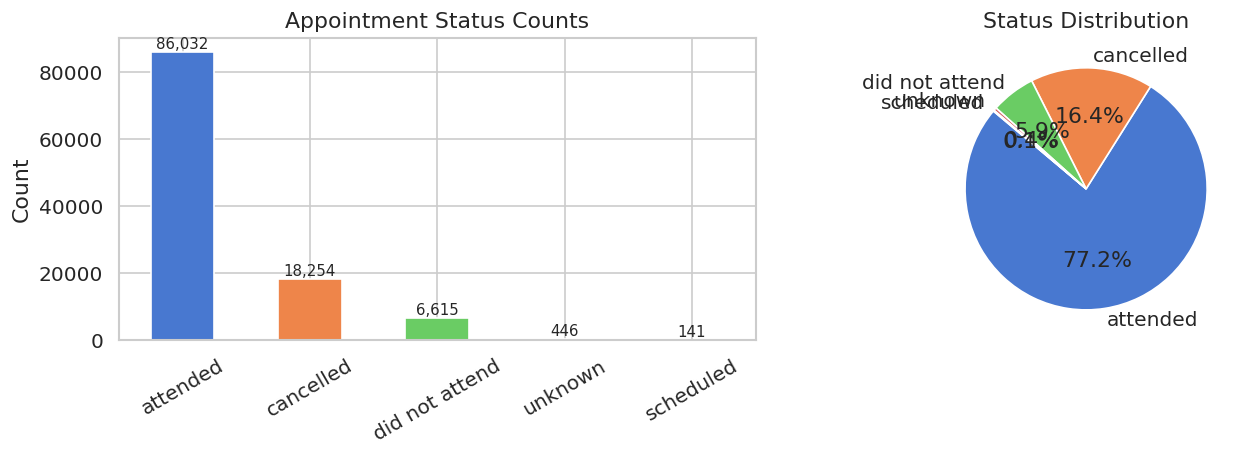

In [5]:
# ── Status breakdown ──────────────────────────────────────────────────────────
status_counts = df['status'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
status_counts.plot(kind='bar', ax=axes[0], color=sns.color_palette('muted'), edgecolor='white')
axes[0].set_title('Appointment Status Counts')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width()/2, p.get_height()),
                     ha='center', va='bottom', fontsize=9)

# Pie chart
axes[1].pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
            colors=sns.color_palette('muted'), startangle=140)
axes[1].set_title('Status Distribution')

plt.tight_layout()
save_fig('01_status_breakdown')

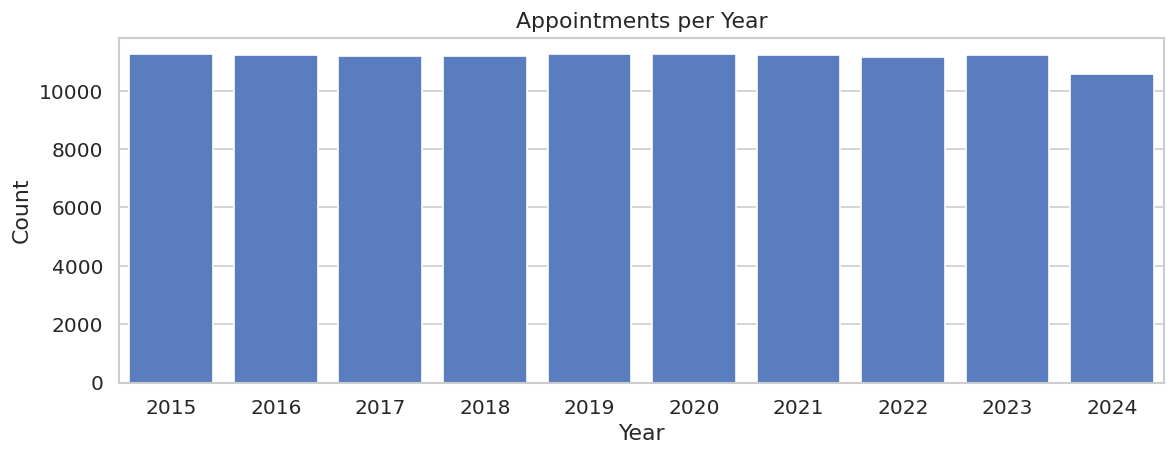

In [6]:
# ── Appointments per year ─────────────────────────────────────────────────────
yearly = df.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(10, 4))
sns.barplot(data=yearly, x='year', y='count', color=sns.color_palette('muted')[0])
plt.title('Appointments per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
save_fig('02_appointments_per_year')

---
## 2. No-Show Deep Dive

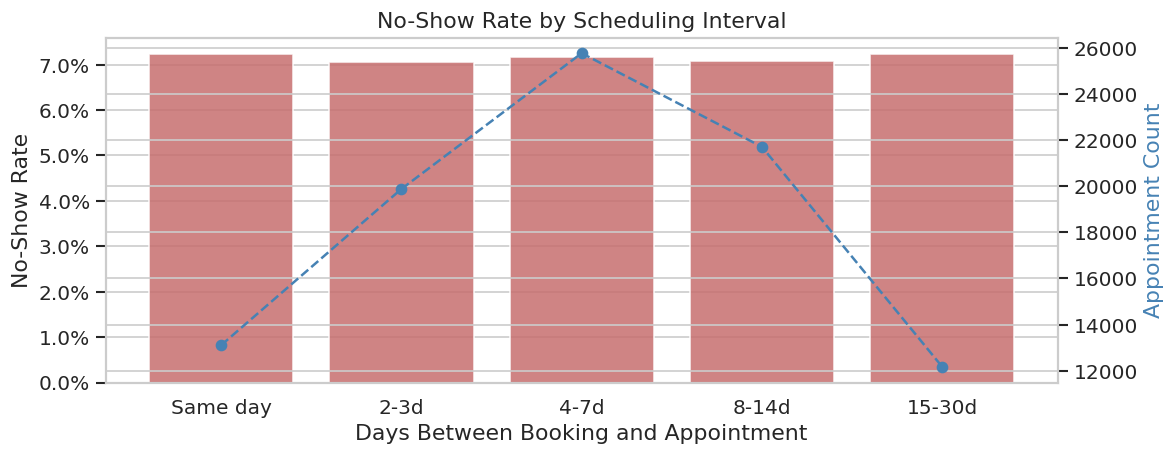

In [7]:
# ── No-show rate by scheduling_interval (binned) ──────────────────────────────
bins   = [0, 1, 3, 7, 14, 30, 60, 999]
labels = ['Same day', '2-3d', '4-7d', '8-14d', '15-30d', '31-60d', '60d+']

model_df['interval_bin'] = pd.cut(
    model_df['scheduling_interval'], bins=bins, labels=labels, right=True
)

interval_noshows = model_df.groupby('interval_bin', observed=True)['no_show'].agg(['mean', 'count']).reset_index()
interval_noshows.columns = ['interval_bin', 'no_show_rate', 'count']

fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

sns.barplot(data=interval_noshows, x='interval_bin', y='no_show_rate', ax=ax1,
            color=sns.color_palette('muted')[3], alpha=0.85)
ax2.plot(range(len(interval_noshows)), interval_noshows['count'], 'o--',
         color='steelblue', label='Count')

ax1.set_title('No-Show Rate by Scheduling Interval')
ax1.set_xlabel('Days Between Booking and Appointment')
ax1.set_ylabel('No-Show Rate')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_ylabel('Appointment Count', color='steelblue')
plt.tight_layout()
save_fig('03_noshows_by_interval')

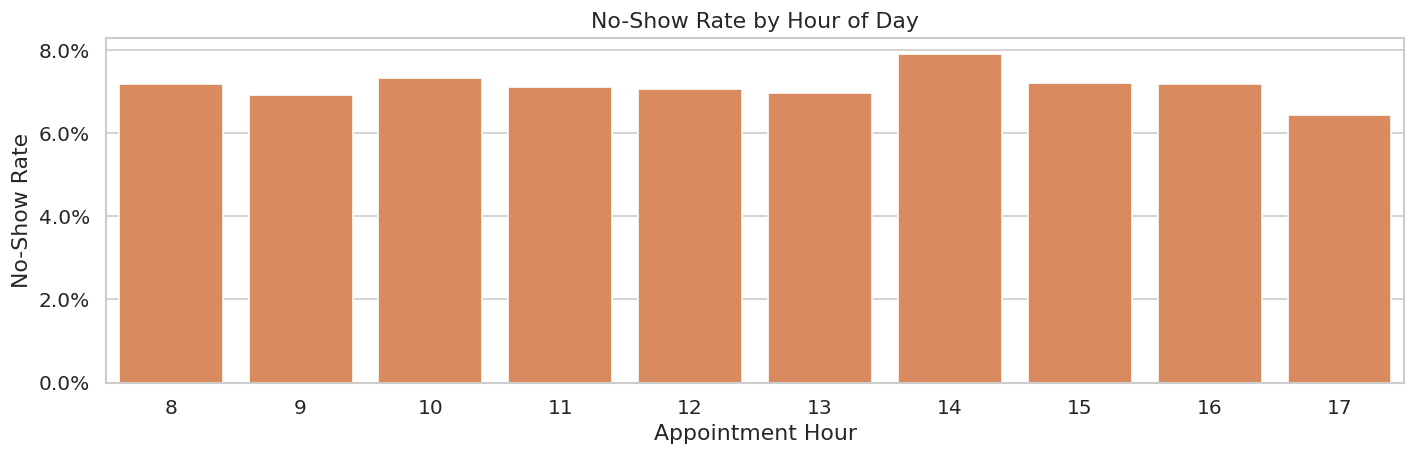

In [8]:
# ── No-show rate by hour of day ───────────────────────────────────────────────
hour_noshows = model_df.groupby('hour')['no_show'].mean().reset_index()

plt.figure(figsize=(12, 4))
sns.barplot(data=hour_noshows, x='hour', y='no_show',
            color=sns.color_palette('muted')[1])
plt.title('No-Show Rate by Hour of Day')
plt.xlabel('Appointment Hour')
plt.ylabel('No-Show Rate')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
save_fig('04_noshows_by_hour')

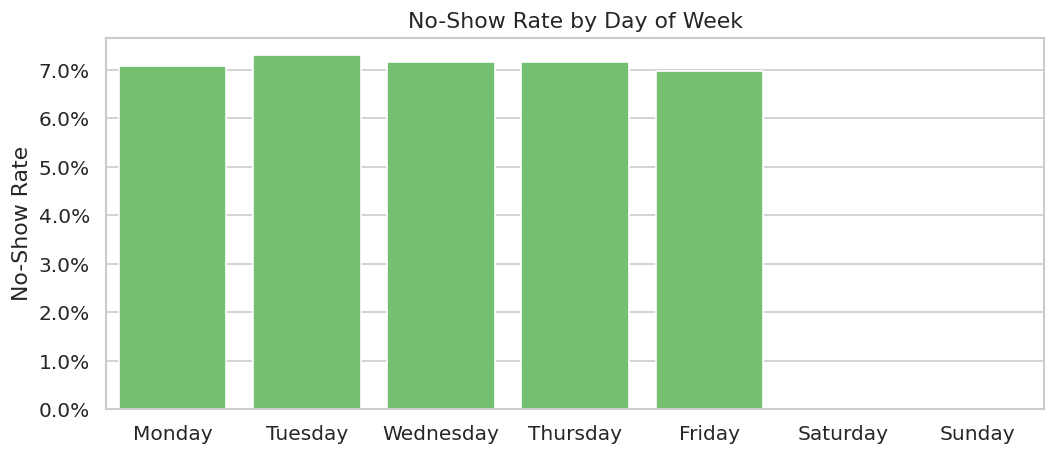

In [9]:
# ── No-show rate by day of week ───────────────────────────────────────────────
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_noshows = model_df.groupby('day_of_week')['no_show'].mean().reindex(dow_order).reset_index()

plt.figure(figsize=(9, 4))
sns.barplot(data=dow_noshows, x='day_of_week', y='no_show',
            color=sns.color_palette('muted')[2])
plt.title('No-Show Rate by Day of Week')
plt.xlabel('')
plt.ylabel('No-Show Rate')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
save_fig('05_noshows_by_dow')

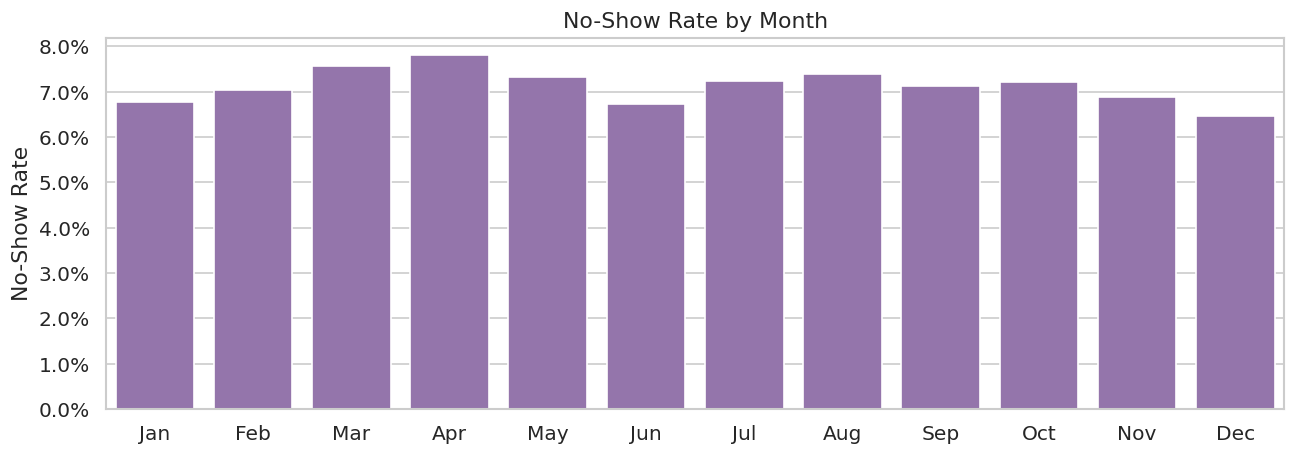

In [10]:
# ── No-show rate by month ─────────────────────────────────────────────────────
month_noshows = model_df.groupby('month')['no_show'].mean().reset_index()
month_names   = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_noshows['month_name'] = month_noshows['month'].apply(lambda m: month_names[m-1])

plt.figure(figsize=(11, 4))
sns.barplot(data=month_noshows, x='month_name', y='no_show',
            color=sns.color_palette('muted')[4])
plt.title('No-Show Rate by Month')
plt.xlabel('')
plt.ylabel('No-Show Rate')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
save_fig('06_noshows_by_month')

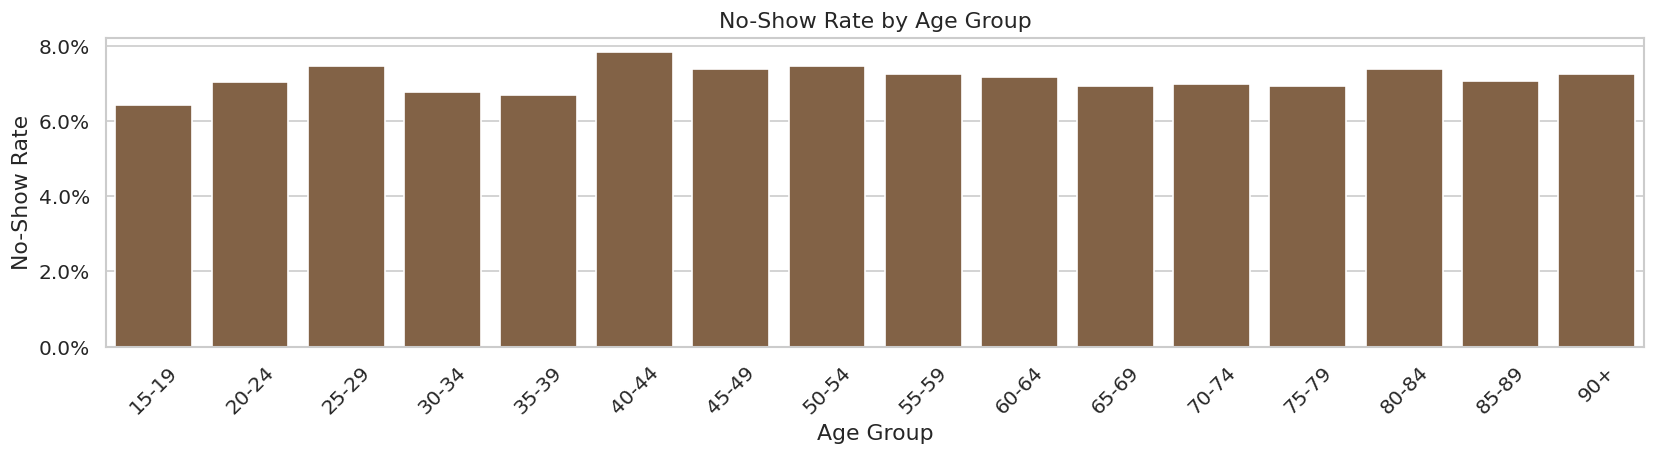

In [11]:
# ── No-show rate by age group ─────────────────────────────────────────────────
age_noshows = model_df.groupby('age_group')['no_show'].agg(['mean','count']).reset_index()
age_noshows.columns = ['age_group', 'no_show_rate', 'count']
age_noshows = age_noshows.sort_values('age_group')

plt.figure(figsize=(14, 4))
sns.barplot(data=age_noshows, x='age_group', y='no_show_rate',
            color=sns.color_palette('muted')[5])
plt.title('No-Show Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('No-Show Rate')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
save_fig('07_noshows_by_age_group')

   sex  no_show_rate  count
Female      0.070914  54996
  Male      0.072110  37651


/tmp/ipykernel_3311/541591933.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sex_noshows, x='sex', y='no_show_rate',


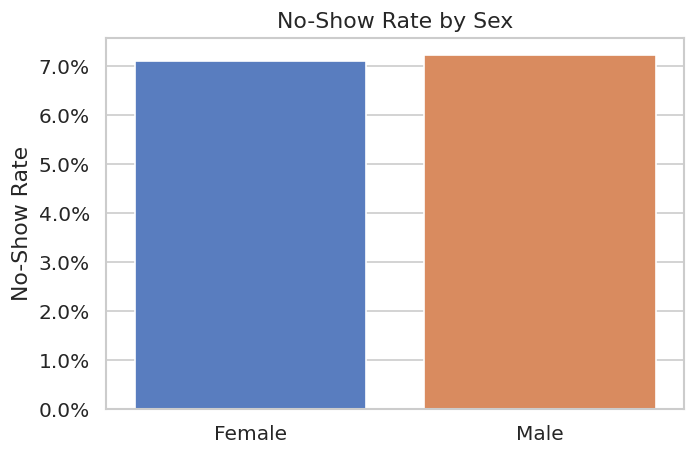

In [12]:
# ── No-show rate by sex ───────────────────────────────────────────────────────
sex_noshows = model_df.groupby('sex')['no_show'].agg(['mean', 'count']).reset_index()
sex_noshows.columns = ['sex', 'no_show_rate', 'count']
print(sex_noshows.to_string(index=False))

plt.figure(figsize=(6, 4))
sns.barplot(data=sex_noshows, x='sex', y='no_show_rate',
            palette='muted')
plt.title('No-Show Rate by Sex')
plt.xlabel('')
plt.ylabel('No-Show Rate')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
save_fig('08_noshows_by_sex')

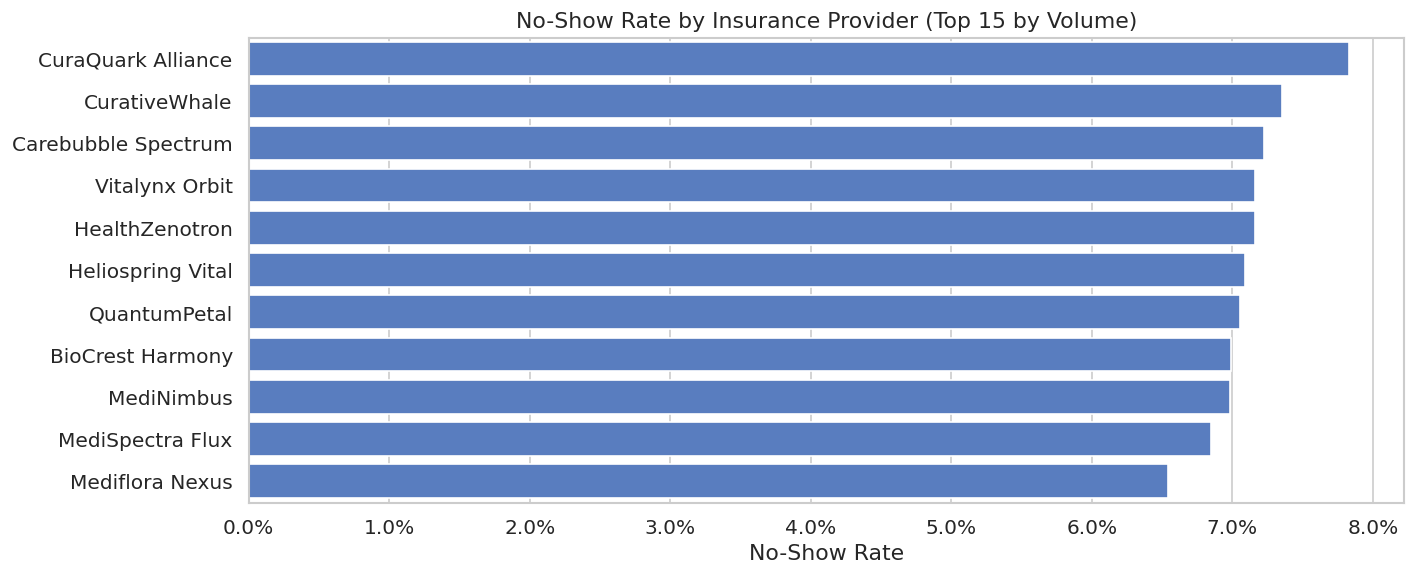

In [13]:
# ── No-show rate by insurance provider (top 15 by volume) ────────────────────
top_insurers = model_df['insurance'].value_counts().head(15).index
ins_noshows  = (
    model_df[model_df['insurance'].isin(top_insurers)]
    .groupby('insurance')['no_show']
    .agg(['mean', 'count'])
    .reset_index()
    .sort_values('mean', ascending=False)
)
ins_noshows.columns = ['insurance', 'no_show_rate', 'count']

plt.figure(figsize=(12, 5))
sns.barplot(data=ins_noshows, x='no_show_rate', y='insurance',
            color=sns.color_palette('muted')[0])
plt.title('No-Show Rate by Insurance Provider (Top 15 by Volume)')
plt.xlabel('No-Show Rate')
plt.ylabel('')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
save_fig('09_noshows_by_insurance')

---
## 3. Patient Behaviour

Mean appointments per patient : 3.04
Median                        : 2
Max                           : 19
Patients with only 1 appt     : 11,880 (32.4%)


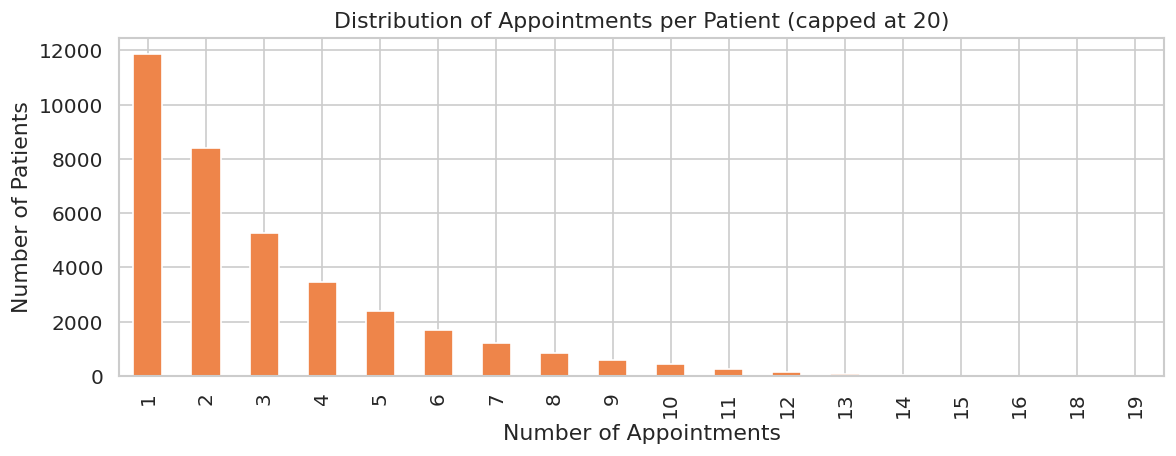

In [14]:
# ── Appointments per patient ──────────────────────────────────────────────────
appts_per_patient = df.groupby('patient_id').size()

print(f'Mean appointments per patient : {appts_per_patient.mean():.2f}')
print(f'Median                        : {appts_per_patient.median():.0f}')
print(f'Max                           : {appts_per_patient.max()}')
print(f'Patients with only 1 appt     : {(appts_per_patient == 1).sum():,} '
      f'({(appts_per_patient == 1).mean()*100:.1f}%)')

plt.figure(figsize=(10, 4))
appts_per_patient.clip(upper=20).value_counts().sort_index().plot(kind='bar', color=sns.color_palette('muted')[1])
plt.title('Distribution of Appointments per Patient (capped at 20)')
plt.xlabel('Number of Appointments')
plt.ylabel('Number of Patients')
plt.tight_layout()
save_fig('10_appts_per_patient')

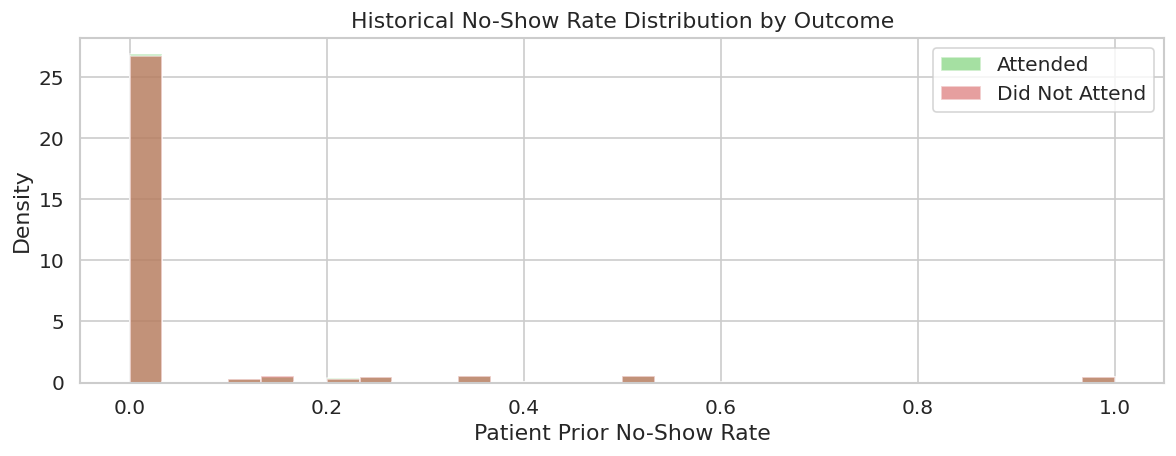

In [15]:
# ── Repeat no-showers ─────────────────────────────────────────────────────────
# Load features.csv for historical rate columns
feat_df = pd.read_csv(
    '../data/processed/features.csv',
    dtype={'appointment_id': str, 'patient_id': str},
    low_memory=False,
)

# Distribution of patient_prior_noshows_rate split by no_show
attended_rate  = feat_df[feat_df['no_show'] == 0]['patient_prior_noshows_rate']
noshow_rate    = feat_df[feat_df['no_show'] == 1]['patient_prior_noshows_rate']

plt.figure(figsize=(10, 4))
plt.hist(attended_rate, bins=30, alpha=0.6, label='Attended',      color=sns.color_palette('muted')[2], density=True)
plt.hist(noshow_rate,   bins=30, alpha=0.6, label='Did Not Attend', color=sns.color_palette('muted')[3], density=True)
plt.title('Historical No-Show Rate Distribution by Outcome')
plt.xlabel('Patient Prior No-Show Rate')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
save_fig('11_prior_noshowrate_dist')

In [16]:
# ── Patients with zero prior history ─────────────────────────────────────────
zero_history = (feat_df['patient_prior_appointments'] == 0).sum()
print(f'Appointments with no prior history : {zero_history:,} ({zero_history/len(feat_df)*100:.1f}%)')
print(f'These default to prior_noshows_rate = 0.0')

Appointments with no prior history : 30,703 (33.1%)
These default to prior_noshows_rate = 0.0


---
## 4. Schedule Patterns

Mean daily utilization : 1.08
Median                 : 1.07


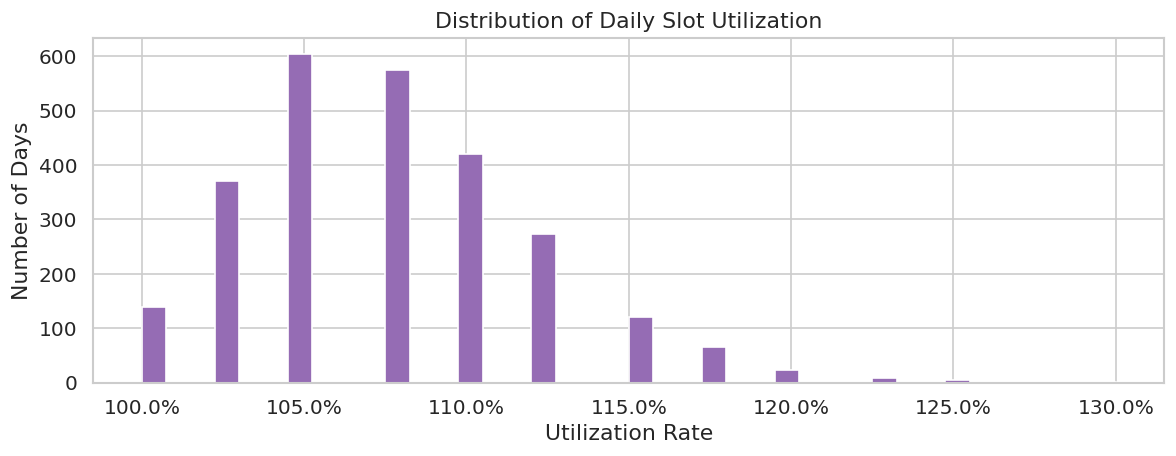

In [17]:
# ── Daily slot utilization distribution ──────────────────────────────────────
daily_util = df.groupby('appointment_date').apply(
    lambda x: x['slot_id'].count() / x['slot_id'].nunique(), include_groups=False
).reset_index(name='utilization')

print(f"Mean daily utilization : {daily_util['utilization'].mean():.2f}")
print(f"Median                 : {daily_util['utilization'].median():.2f}")

plt.figure(figsize=(10, 4))
plt.hist(daily_util['utilization'], bins=40, color=sns.color_palette('muted')[4], edgecolor='white')
plt.title('Distribution of Daily Slot Utilization')
plt.xlabel('Utilization Rate')
plt.ylabel('Number of Days')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
save_fig('12_daily_utilization_dist')

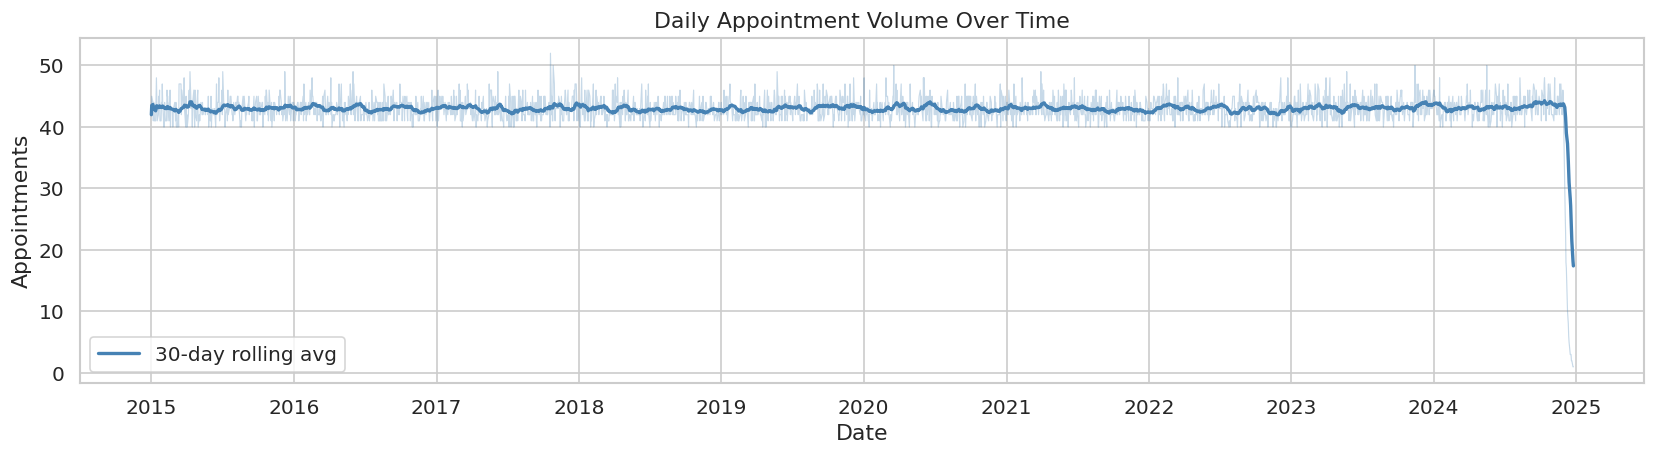

In [18]:
# ── Appointments per day over time ────────────────────────────────────────────
daily_counts = df.groupby('appointment_date').size().reset_index(name='count')
daily_counts['appointment_date'] = pd.to_datetime(daily_counts['appointment_date'])

# Monthly rolling average for readability
daily_counts = daily_counts.set_index('appointment_date').sort_index()
rolling_30   = daily_counts['count'].rolling('30D').mean()

plt.figure(figsize=(14, 4))
plt.plot(daily_counts.index, daily_counts['count'], alpha=0.3, color='steelblue', lw=0.7)
plt.plot(rolling_30.index,   rolling_30,            color='steelblue', lw=2, label='30-day rolling avg')
plt.title('Daily Appointment Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Appointments')
plt.legend()
plt.tight_layout()
save_fig('13_daily_volume_over_time')

---
## 5. Data Quality

In [19]:
# ── Investigate unknown / scheduled rows ─────────────────────────────────────
odd_statuses = df[df['status'].isin(['unknown', 'scheduled'])].copy()
print(f"Rows with unexpected status: {len(odd_statuses):,}")
print(f"\nStatus counts:")
print(odd_statuses['status'].value_counts().to_string())
print(f"\nYear distribution:")
print(odd_statuses['year'].value_counts().sort_index().to_string())
print(f"\nSample rows:")
odd_statuses[['appointment_id','appointment_date','status','patient_id','scheduling_interval']].head(10)

Rows with unexpected status: 587

Status counts:
status
unknown      446
scheduled    141

Year distribution:
year
2015     49
2016     32
2017     39
2018     52
2019     43
2020     50
2021     54
2022     47
2023     39
2024    182

Sample rows:


,appointment_id,appointment_date,status,patient_id,scheduling_interval
63,0000083,2015-01-02,unknown,01417,8
1105,0000728,2015-02-05,unknown,03115,20
1152,0001063,2015-02-06,unknown,00107,9
1652,0001824,2015-02-24,unknown,00576,2
1728,0001850,2015-02-26,unknown,03411,3
2041,0002197,2015-03-09,unknown,05741,2
2053,0002218,2015-03-09,unknown,02630,1
2114,0001751,2015-03-11,unknown,01442,19
2119,0002312,2015-03-11,unknown,06274,1
2261,0002229,2015-03-16,unknown,06043,8


In [20]:
# ── Timing data completeness for attended appointments ────────────────────────
attended = df[df['status'] == 'attended'].copy()
timing_cols = ['check_in_time', 'start_time', 'end_time', 'appointment_duration', 'waiting_time']

print('Missing timing data in attended appointments:')
for col in timing_cols:
    missing = attended[col].isnull().sum()
    print(f'  {col:<25} {missing:>5,}  ({missing/len(attended)*100:.1f}%)')

Missing timing data in attended appointments:
  check_in_time                 0  (0.0%)
  start_time                    0  (0.0%)
  end_time                      0  (0.0%)
  appointment_duration          0  (0.0%)
  waiting_time                  0  (0.0%)


In [21]:
# ── Off-by-one patient count ──────────────────────────────────────────────────
patients_raw = pd.read_csv('../data/raw/patients.csv', dtype={'patient_id': str})
patients_raw['patient_id'] = patients_raw['patient_id'].str.zfill(5)

print(f'Patients in patients.csv : {len(patients_raw):,}')
print(f'Unique patients in master: {df["patient_id"].nunique():,}')

# Find any patient_ids in patients.csv not in master
missing_from_master = set(patients_raw['patient_id']) - set(df['patient_id'])
print(f'\nPatients in patients.csv but no appointments in master: {len(missing_from_master)}')
if missing_from_master:
    print(patients_raw[patients_raw['patient_id'].isin(missing_from_master)])

Patients in patients.csv : 36,697
Unique patients in master: 36,697

Patients in patients.csv but no appointments in master: 0


---
## 6. Correlation & Feature Importance Preview

In [22]:
# ── Point-biserial correlation with no_show ───────────────────────────────────
# Measures linear correlation between each numeric feature and the binary target

numeric_features = [
    'scheduling_interval', 'hour', 'month', 'age',
    'patient_prior_noshows', 'patient_prior_noshows_rate',
    'patient_prior_appointments', 'daily_slot_utilization',
    'rolling_7d_noshows_rate',
]

# Use features.csv which has all engineered columns
corr_results = []
for col in numeric_features:
    if col in feat_df.columns:
        clean = feat_df[['no_show', col]].dropna()
        r, p = stats.pointbiserialr(clean['no_show'], clean[col])
        corr_results.append({'feature': col, 'correlation': r, 'p_value': p})

corr_df = pd.DataFrame(corr_results).sort_values('correlation', key=abs, ascending=False)
print(corr_df.to_string(index=False))

                   feature  correlation  p_value
patient_prior_appointments     0.003655 0.265872
     patient_prior_noshows     0.003316 0.312885
   rolling_7d_noshows_rate    -0.003089 0.347130
patient_prior_noshows_rate     0.002293 0.485270
    daily_slot_utilization     0.001078 0.742770
                       age     0.000812 0.804676
       scheduling_interval     0.000089 0.978369


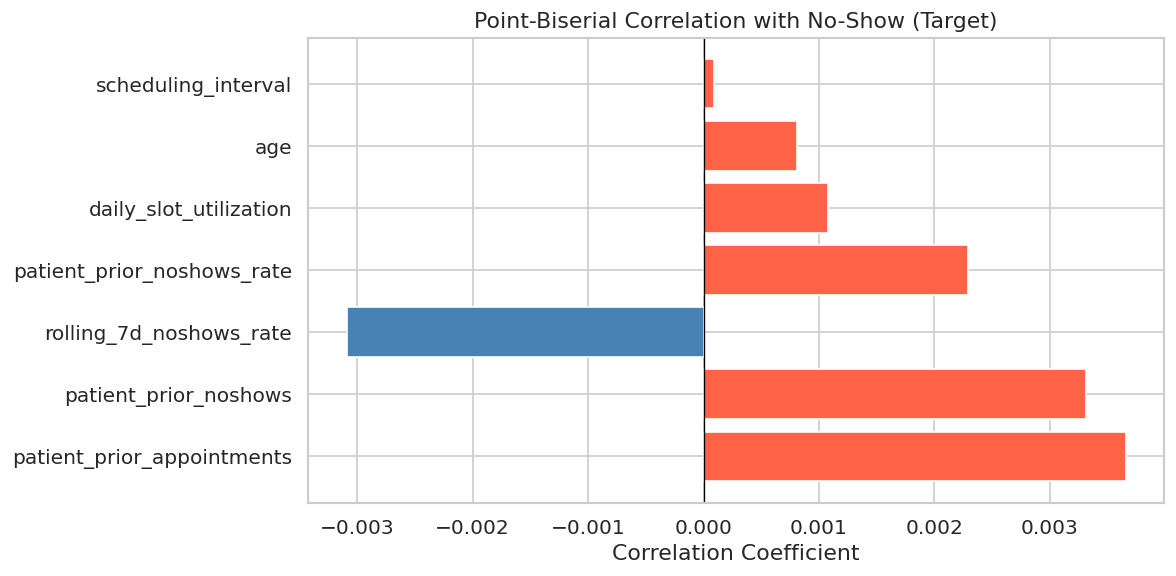

In [23]:
# ── Correlation bar chart ─────────────────────────────────────────────────────
plt.figure(figsize=(10, 5))
colors = ['tomato' if x > 0 else 'steelblue' for x in corr_df['correlation']]
plt.barh(corr_df['feature'], corr_df['correlation'], color=colors)
plt.axvline(0, color='black', lw=0.8)
plt.title('Point-Biserial Correlation with No-Show (Target)')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
save_fig('14_feature_correlations')

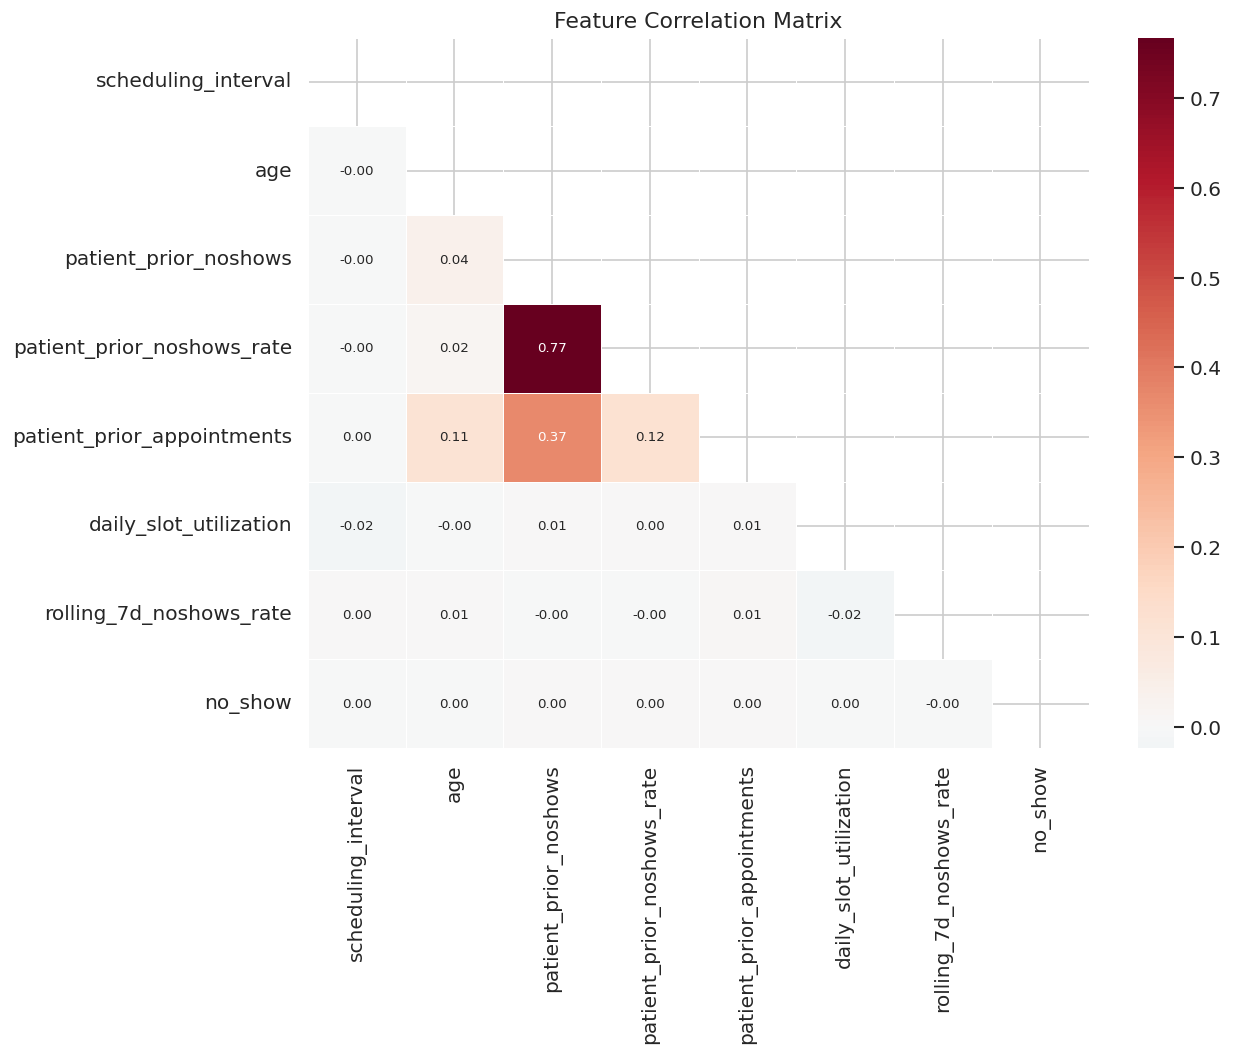

In [24]:
# ── Correlation matrix of all numeric features ────────────────────────────────
feat_corr_cols = [c for c in numeric_features if c in feat_df.columns]
corr_matrix = feat_df[feat_corr_cols + ['no_show']].corr()

plt.figure(figsize=(11, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, linewidths=0.5,
            annot_kws={'size': 8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
save_fig('15_correlation_matrix')

In [25]:
# ── Summary printout ──────────────────────────────────────────────────────────
print('=== EDA Complete ===')
print(f'Figures saved to: {FIGURE_DIR}')
print(f'\nKey takeaways to document before moving to classifier.py:')
print('  1. Overall no-show rate in model set')
print('  2. Strongest features by correlation (check corr_df above)')
print('  3. Any data quality issues that need handling in features.py')
print('  4. Class imbalance ratio (for scale_pos_weight in XGBoost)')
neg = (feat_df['no_show'] == 0).sum()
pos = (feat_df['no_show'] == 1).sum()
print(f'\n  scale_pos_weight suggestion: {neg/pos:.2f}  (attended / did-not-attend)')

=== EDA Complete ===
Figures saved to: ../outputs/figures

Key takeaways to document before moving to classifier.py:
  1. Overall no-show rate in model set
  2. Strongest features by correlation (check corr_df above)
  3. Any data quality issues that need handling in features.py
  4. Class imbalance ratio (for scale_pos_weight in XGBoost)

  scale_pos_weight suggestion: 13.01  (attended / did-not-attend)
